In [11]:
import torch.nn as nn
class HeightNet(nn.Module):
    def __init__(self, input_size):
        super(HeightNet, self).__init__()
        
        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Output layer
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

In [78]:
import requests
import pandas as pd
import numpy as np
import torch
from torch import nn
import joblib
import os

# ---------------------------
# CONFIG
# ---------------------------
IMAGE_PATH = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/resource/data/data/processed_data/6_NamKhuyuGoi_GiangSeoChinh_1_164.jpg"
API_URL = "http://localhost:5001/v1/height"
CSV_B_PATH = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/src/logic_app/common/csv/2D_distance.csv"
MODEL_TYPE = "RandomForest"  # hoặc "Linear", "NeuralNetwork"


MODEL_PATH_LINEAR= "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/resource/data/model/model_train/LinearRegressionTorch.pt"  # hoặc "RandomForestSklearn.pt"
MODEL_PATH_RANDOM_FOREST= "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/resource/data/model/model_train/RandomForestSklearn.pt"  # hoặc "RandomForestSklearn.pt"
MODEL_PATH_NEURAL_NETWORK= "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/resource/data/model/model_train/HeightNet_best.pt"  # hoặc "RandomForestSklearn.pt"


FEATURES = ["Distance1 (cm)", "Distance2 (cm)", "Distance3 (cm)",
            "Distance4 (cm)", "Distance5 (cm)", "Distance6 (cm)"]
TARGET = "Height_truth (cm)"

# ---------------------------
# 1. Gửi ảnh đến API A
# ---------------------------
with open(IMAGE_PATH, 'rb') as f:
    response = requests.post(API_URL, files={"file": f})
    if response.status_code != 200:
        raise Exception(f"API lỗi: {response.status_code} - {response.text}")
print("✅ Gửi ảnh đến API thành công.")

# ---------------------------
# 2. Đọc dòng cuối từ file CSV B
# ---------------------------
df = pd.read_csv(CSV_B_PATH)
last_row = df.tail(1)

# Lấy đầu vào X và ground truth y
x_input = last_row[FEATURES].values.astype(np.float32)
y_true = float(last_row[TARGET].values[0])

# ---------------------------
# 3. Dự đoán từ model
# ---------------------------
if MODEL_TYPE == "Linear":
    model = torch.load(MODEL_PATH_LINEAR)
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(x_input)).item()

elif MODEL_TYPE == "RandomForest":
    model = joblib.load(MODEL_PATH_RANDOM_FOREST)
    y_pred = model.predict(x_input)[0]  # Không cần torch

elif MODEL_TYPE == "NeuralNetwork":
    class HeightNet(nn.Module):
        def __init__(self, input_size=6):
            super(HeightNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Linear(input_size, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.3)
            )
            self.layer2 = nn.Sequential(
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            self.layer3 = nn.Sequential(
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Dropout(0.1)
            )
            self.output = nn.Linear(32, 1)

        def forward(self, x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.output(x)
            return x

    model = torch.load(MODEL_PATH_NEURAL_NETWORK)
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(x_input)).item()

else:
    raise ValueError(f"MODEL_TYPE không hợp lệ: {MODEL_TYPE}")

# ---------------------------
# 4. In kết quả
# ---------------------------
print("\n🔍 Kết quả dự đoán:")
print(f"  🔹 Ground truth (Height_truth): {y_true:.2f}")
print(f"  🔹 Model dự đoán:               {y_pred:.2f}")
print(f"  🔹 Sai số tuyệt đối:           {abs(y_pred - y_true):.2f} cm")


✅ Gửi ảnh đến API thành công.

🔍 Kết quả dự đoán:
  🔹 Ground truth (Height_truth): 164.00
  🔹 Model dự đoán:               169.43
  🔹 Sai số tuyệt đối:           5.43 cm


# Vẽ VD

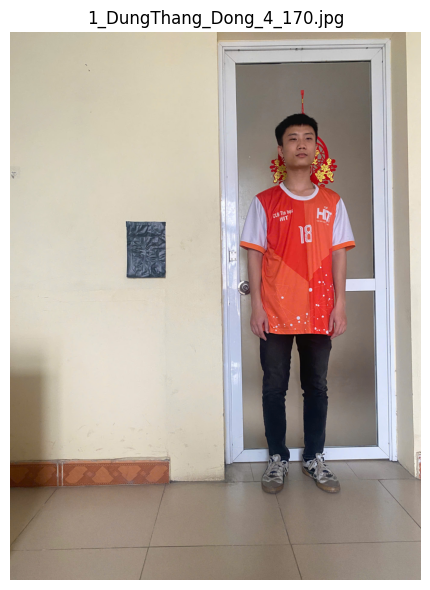

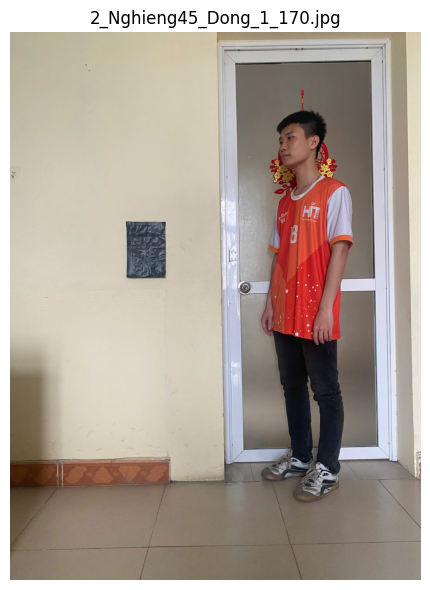

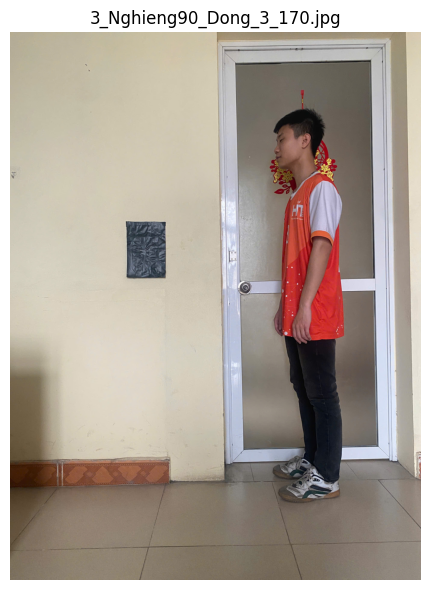

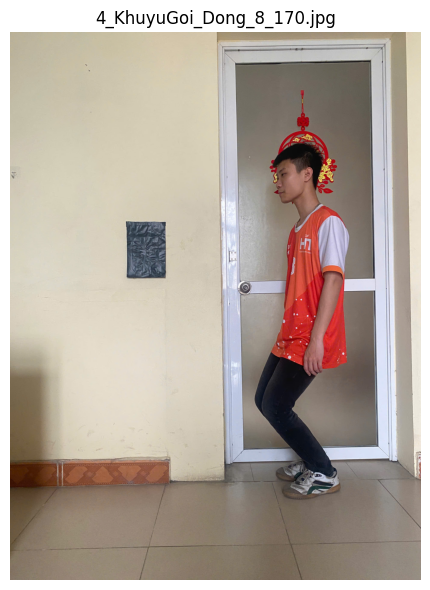

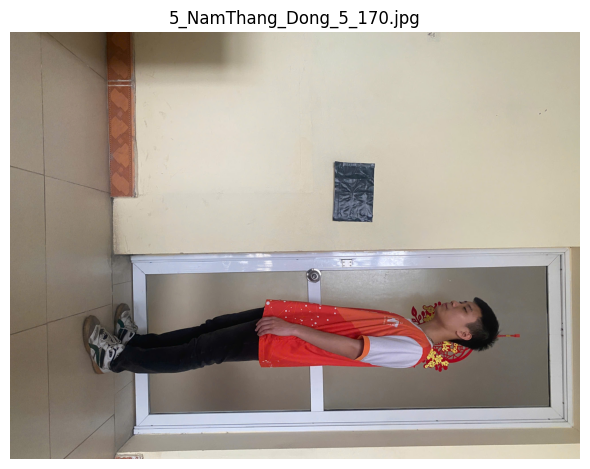

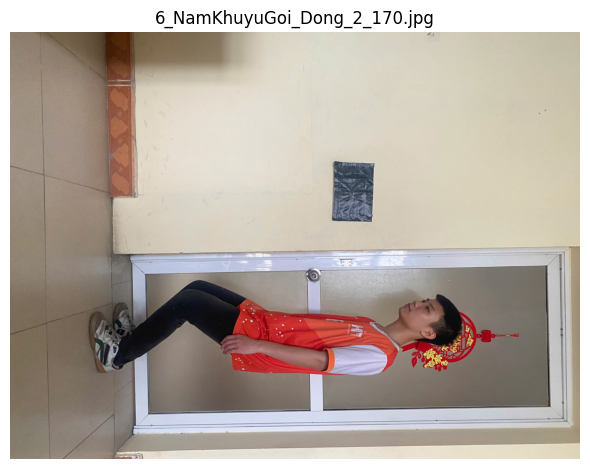

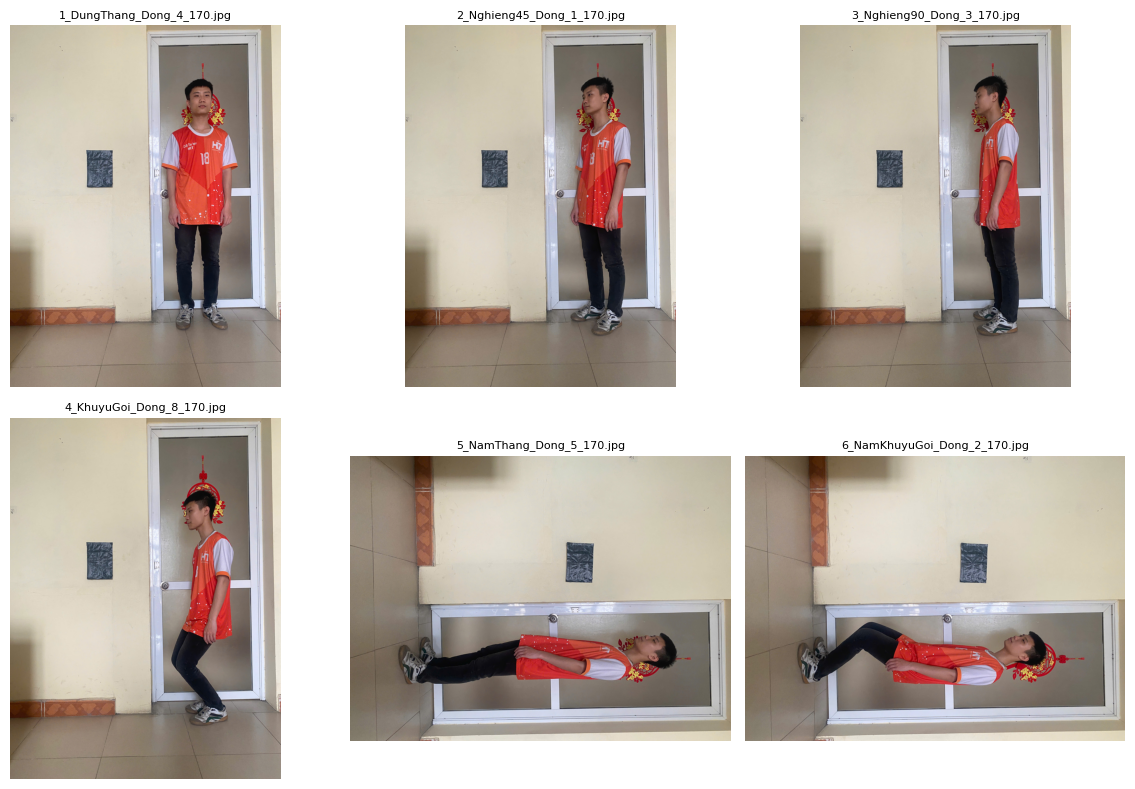

In [88]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ----------------------------
# Đường dẫn thư mục ảnh
# ----------------------------
IMAGE_DIR = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/resource/data/data/processed_data"

# ----------------------------
# Lọc ảnh có chữ "Dong" và giữ 1 ảnh theo từ thứ 2
# ----------------------------
image_files = [f for f in os.listdir(IMAGE_DIR)
               if "Dong" in f and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Tạo dict để lưu ảnh đại diện theo từ thứ 2
representative_files = {}
for filename in sorted(image_files):
    parts = filename.split("_")
    if len(parts) >= 3 and "Dong" in parts[2]:
        key = parts[1]  # từ thứ 2 (bỏ qua số đầu)
        if key not in representative_files:
            representative_files[key] = filename

# ----------------------------
# Hiển thị từng ảnh đơn lẻ trước
# ----------------------------
for key, filename in representative_files.items():
    img_path = os.path.join(IMAGE_DIR, filename)
    img = mpimg.imread(img_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"{filename}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()  # Hiển thị từng ảnh riêng

# ----------------------------
# Gộp tất cả ảnh lại trong 1 hình (subplot)
# ----------------------------
num_images = len(representative_files)
cols = 3
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(cols * 4, rows * 4))

for idx, (key, filename) in enumerate(representative_files.items()):
    img_path = os.path.join(IMAGE_DIR, filename)
    img = mpimg.imread(img_path)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(filename, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
import os
import pandas as pd
import numpy as np
import joblib
import torch
from torch import nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import requests

# ---------------------------
# CONFIG
# ---------------------------
FOLDER_PATH = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/resource/data/data/processed_data"
API_URL = "http://localhost:5001/v1/height"
CSV_B_PATH = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/src/logic_app/common/csv/2D_distance.csv"

MODEL_PATH_LINEAR = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/resource/data/model/model_train/LinearRegressionTorch.pt"
MODEL_PATH_RANDOM_FOREST = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/resource/data/model/model_train/RandomForestSklearn.pt"
MODEL_PATH_NEURAL_NETWORK = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/src/model_deployed/common/weights/HeightNet_best2.pt"

FEATURES = ["Distance1 (cm)", "Distance2 (cm)", "Distance3 (cm)",
            "Distance4 (cm)", "Distance5 (cm)", "Distance6 (cm)"]
TARGET = "Height_truth (cm)"

# ---------------------------
# Load mô hình HeightNet class
# ---------------------------
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)
class HeightNet(nn.Module):
    def __init__(self, input_size=6):
        super(HeightNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

# ---------------------------
# Hàm dự đoán theo model
# ---------------------------
def predict_and_evaluate(model_type, model):
    y_trues = []
    y_preds = []

    for file_name in sorted(os.listdir(FOLDER_PATH)):
        if not file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(FOLDER_PATH, file_name)

        with open(image_path, 'rb') as f:
            response = requests.post(API_URL, files={"file": f})
            if response.status_code != 200:
                continue  # Skip failed
            df = pd.read_csv(CSV_B_PATH)
            last_row = df.tail(1)
            x_input = last_row[FEATURES].values.astype(np.float32)
            y_true = float(last_row[TARGET].values[0])

            if model_type in ["Linear", "NeuralNetwork"]:
                with torch.no_grad():
                    model.eval()
                    tensor_input = torch.tensor(x_input)
                    if model_type == "NeuralNetwork":
                        tensor_input = tensor_input.view(1, -1)
                    y_pred = model(tensor_input).item()
            elif model_type == "RandomForest":
                y_pred = model.predict(x_input)[0]

            y_trues.append(y_true)
            y_preds.append(y_pred)

    # Evaluate
    mae = mean_absolute_error(y_trues, y_preds)
    mse = mean_squared_error(y_trues, y_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_trues, y_preds)

    return {
        "Model": model_type,
        "MAE (cm)": mae,
        "MSE": mse,
        "RMSE (cm)": rmse,
        "R² Score": r2
    }

# ---------------------------
# Load và chạy cả 3 model
# ---------------------------
results = []

# Linear Regression
linear_model = torch.load(MODEL_PATH_LINEAR)
results.append(predict_and_evaluate("Linear", linear_model))

# Random Forest
rf_model = joblib.load(MODEL_PATH_RANDOM_FOREST)
results.append(predict_and_evaluate("RandomForest", rf_model))

# Neural Network (HeightNet)
nn_model = torch.load(MODEL_PATH_NEURAL_NETWORK)
results.append(predict_and_evaluate("NeuralNetwork", nn_model))

# ---------------------------
# In bảng kết quả
# ---------------------------
df_results = pd.DataFrame(results)
print("So sánh kết quả dự đoán của 3 mô hình:")
print(df_results)


/tmp/ipykernel_18268/1794800327.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  linear_model = torch.load(MODEL_PATH_LINEAR)
/tmp/ipykernel_18268/1794800327.py:127: Fu

So sánh kết quả dự đoán của 3 mô hình:
           Model   MAE (cm)         MSE  RMSE (cm)   R² Score
0         Linear  16.840735  384.778530  19.615772 -13.201490
1   RandomForest   3.996324   26.619550   5.159414   0.017520
2  NeuralNetwork  22.421800  762.600771  27.615227 -27.146236


In [ ]:
MODEL_PATH_NEURAL_NETWORK = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_PhamDangDong/DATN_PhamDangDong/src/model_deployed/common/weights/HeightNet_best2.pt"
